## Импортируем основную хрень

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
saved_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

import import_ipynb
from lr4 import r_standard as r, cor, space_middle
import lr3_x as X
import lr3_y as Y

sys.stdout = saved_stdout;

In [139]:
source = pd.read_csv('dataset.csv', header=None)
N = len(source)
source.head()

,0,1
0,405,107.5
1,521,154.9
2,382,98.1
3,362,111.7
4,444,130.0


In [140]:
params = pd.DataFrame(data={
    "mean": [X.x_middle, Y.x_middle],
    "variance": [X.disp, Y.disp],
    "sd": [X.S, Y.S],
}, index=["u","v"])
print(params)

         mean     variance         sd
u  453.280702  2541.960680  50.640457
v  129.843860   439.691059  21.061390


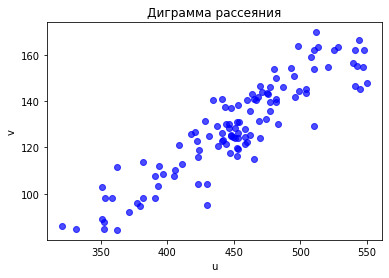

In [141]:
plt.scatter(source[0], source[1], alpha=0.7, color="b")
plt.xlabel("u")
plt.ylabel("v")
plt.title("Диграмма рассеяния")
plt.show()

## Уравнение среднеквадратической регрессии

In [142]:
params["reg_coeff"] = [
    r * params.loc["u", "sd"] / params.loc["v", "sd"], 
    r * params.loc["v", "sd"] / params.loc["u", "sd"]
]
print(params)

         mean     variance         sd  reg_coeff
u  453.280702  2541.960680  50.640457   2.141776
v  129.843860   439.691059  21.061390   0.370470


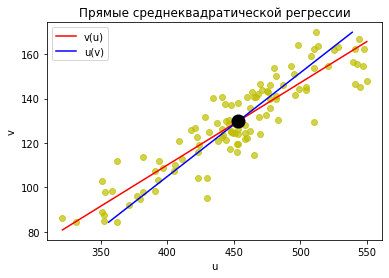

In [143]:
def reg_X(y):
    return params.loc["u", "mean"] + params.loc["u", "reg_coeff"] * (y - params.loc["v", "mean"])

def reg_Y(x):
    return params.loc["v", "mean"] + params.loc["v", "reg_coeff"] * (x - params.loc["u", "mean"])


plt.scatter(source[0], source[1], alpha=0.7, color="y")
plt.plot(source[0].sort_values(), reg_Y(source[0].sort_values()), label="v(u)", color="r")
plt.plot(reg_X(source[1].sort_values()), source[1].sort_values(), label="u(v)", color="b")
plt.plot(params.loc["u", "mean"], params.loc["v", "mean"], color="k", marker="o", mew=2, ms=12)

plt.xlabel("u")
plt.ylabel("v")
plt.title("Прямые среднеквадратической регрессии")
plt.legend()
plt.show()

остаточная дисперсия

In [144]:
params["err_var"] = params["sd"]**2 * (1 - r**2)
print(params)

         mean     variance         sd  reg_coeff     err_var
u  453.280702  2541.960680  50.640457   2.141776  529.654346
v  129.843860   439.691059  21.061390   0.370470   91.616004


In [145]:
cor1 = cor.copy()

u_middles = list(map(lambda x: round(x, 1), map(space_middle, X.spaces)))
v_middles = list(map(lambda x: round(x, 1), map(space_middle, Y.spaces)))

N_u = cor1.sum(axis=1)
N_v = cor1.sum(axis=0)

mean_u = np.sum(cor1 * v_middles, axis=1) / N_u
mean_v = np.sum(cor1.transpose() * u_middles, axis=1) / N_v

cor1["N_u"] = N_u
cor1["mean_u"] = mean_u
cor1 = pd.concat([cor1, pd.DataFrame([N_v, mean_v])])

cor1.columns = pd.Index([*v_middles, "N_u", "mean_u"], name="v")
cor1.index = pd.Index([*u_middles, "N_v", "mean_v"], name="u")

cor1 = cor1.round(1)
cor1.iloc[:-2,:-2] = cor1.iloc[:-2,:-2].round()

cor1


v,89.8,100.8,111.8,122.8,133.8,144.8,155.8,166.8,N_u,mean_u
u,,,,,,,,,,
335.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,89.8
364.5,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,96.4
393.5,1.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,10.0,106.3
422.5,0.0,3.0,2.0,6.0,1.0,1.0,0.0,0.0,13.0,118.6
451.5,0.0,0.0,2.0,19.0,11.0,4.0,0.0,0.0,36.0,128.0
480.5,0.0,0.0,0.0,1.0,4.0,12.0,2.0,0.0,19.0,142.5
509.5,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,13.0,154.1
538.5,0.0,0.0,0.0,0.0,0.0,3.0,3.0,5.0,11.0,157.8
N_v,8.0,10.0,11.0,26.0,17.0,24.0,9.0,9.0,NaN,NaN


In [146]:
var_v_u = np.sum(cor * (
    np.tile(v_middles, (len(mean_u), 1)) -  
    np.tile(mean_u, (len(v_middles), 1)).transpose()
    )**2, 
    axis=1) / N_u
var_v_in = sum(var_v_u * N_u) / N
var_v_across = sum(N_u * (mean_u - params.loc["v", "mean"]) ** 2) / N

var_u_v = np.sum(cor.transpose() * (
    np.tile(u_middles, (len(mean_v), 1)) -  
    np.tile(mean_v, (len(u_middles), 1)).transpose()
    )**2, 
    axis=1) / N_v
var_u_in = sum(var_u_v * N_v) / N
var_u_across = sum(N_v * (mean_v - params.loc["u", "mean"]) ** 2) / N

variances = pd.DataFrame(data={
    "within groups": [var_v_in, var_u_in],
    "across groups": [var_v_across, var_u_across],
    "within + across": [var_v_in + var_v_across, var_u_in + var_u_across],
    "sample variance": [params.loc["v", "variance"], params.loc["u", "variance"]]
    }, index=["v", "u"])
variances

,within groups,across groups,within + across,sample variance
v,80.067729,359.623330,439.691059,439.691059
u,461.182198,2080.778482,2541.960680,2541.960680


Выборочное корреляционное отношение

$$ \bar{\eta}_{yx} = \frac{{\sigma}_{\bar{y}}}{\sigma_y} = \frac{\sqrt{D_{\bar{y}}}}{\sqrt{D_y}}. $$ 


In [147]:
eta_v_u = np.sqrt(variances.loc['v', "across groups"] / params.loc["v", "variance"])
eta_u_v = np.sqrt(variances.loc['u', "across groups"] / params.loc["u", "variance"])
print(eta_v_u)
print(eta_u_v)

0.9043782558968885
0.9047498291801275


строим параболическую корреляционную кривую

In [148]:
left_v_u = [
    [sum(source[0]**4), sum(source[0]**3), sum(source[0]**2)],
    [sum(source[0]**3), sum(source[0]**2), sum(source[0])],
    [sum(source[0]**2), sum(source[0]), N]]
right_v_u = [
    sum(source[1] * source[0]**2), 
    sum(source[1] * source[0]), 
    sum(source[1])]
a_v, b_v, c_v = np.linalg.solve(left_v_u, right_v_u)

left_u_v = [
    [sum(source[1]**4), sum(source[1]**3), sum(source[1]**2)],
    [sum(source[1]**3), sum(source[1]**2), sum(source[1])],
    [sum(source[1]**2), sum(source[1]), N]]
right_u_v = [
    sum(source[0] * source[1]**2), 
    sum(source[0] * source[1]), 
    sum(source[0])]
a_u, b_u, c_u = np.linalg.solve(left_u_v, right_u_v)

parab_coeffs = pd.DataFrame(data={
    "a": [a_v, a_u], 
    "b": [b_v, b_u], 
    "c": [c_v, c_u]}, 
    index=["v(u)", "u(v)"])
parab_coeffs

,a,b,c
v(u),-0.000224,0.561539,-78.352315
u(v),-0.004316,3.359413,92.115520


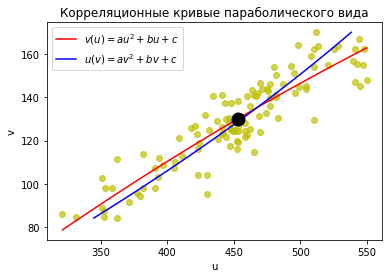

In [149]:
parab_v = lambda u: a_v * u**2 + b_v * u + c_v
parab_u = lambda v: a_u * v**2 + b_u * v + c_u

plt.scatter(source[0], source[1], alpha=0.7, color="y")
plt.plot(source[0].sort_values(), parab_v(source[0].sort_values()), label="$v(u) = a u^2 + b u + c$", color="r")
plt.plot(parab_u(source[1].sort_values()), source[1].sort_values(), label="$u(v) = a v^2 + b v + c$", color="b")
plt.plot(params.loc["u", "mean"], params.loc["v", "mean"], color="k", marker="o", mew=2, ms=12)

plt.xlabel("u")
plt.ylabel("v")
plt.title("Корреляционные кривые параболического вида")
plt.legend()
plt.show()

тут пошла херня по вариантам

$$ -y = \frac{{\beta}_1}{x} + {\beta}_0 $$



In [150]:
vs_x = source[0].sum()
vs_x_y = source.apply(lambda x: x[0] * x[1], axis=1).sum()
vs_x2_y = source.apply(lambda x: x[0]**2 * x[1], axis=1).sum()
vs_x2 = source[0].apply(lambda x: x**2).sum()

beta_0_v = (vs_x * vs_x_y - vs_x2_y) / (vs_x2 - vs_x**2)
beta_1_v = -vs_x_y - beta_0_v * vs_x

us_x = source[1].sum()
us_x_y = source.apply(lambda x: x[1] * x[0], axis=1).sum()
us_x2_y = source.apply(lambda x: x[1]**2 * x[0], axis=1).sum()
us_x2 = source[1].apply(lambda x: x**2).sum()

beta_0_u = (us_x * us_x_y - us_x2_y) / (us_x2 - us_x**2)
beta_1_u = us_x_y + beta_0_u * us_x

custom_v = lambda u: -beta_1_v / u - beta_0_v
custom_u = lambda v: -beta_1_u / v - beta_0_u

coeffs = pd.DataFrame(data={
    "beta_0": [beta_0_v, beta_0_u],
    "beta_1": [beta_1_v, beta_1_u]
}, index = ["v(u)", "u(v)"])
coeffs


,beta_0,beta_1
v(u),-131.123735,-940.559295
u(v),-459.263810,916.301059


In [168]:
vs_y = source[1].sum()
vs_y_d_x = source.apply(lambda x: x[1]/x[0]).sum()
vs__d_x = source[0].apply(lambda x: 1/x).sum()
vs__d_x2 = source[0].apply(lambda x: 1/x**2).sum()

beta_1_v = (vs_y * vs__d_x - vs_y_d_x) / (vs__d_x2 - vs__d_x**2)
beta_0_v = -vs_y - beta_1_v * vs__d_x

custom_v = lambda u: -beta_1_v / u - beta_0_v
print(beta_1_v)
print(beta_0_v)

-57915.28191009413
121.35330711739516


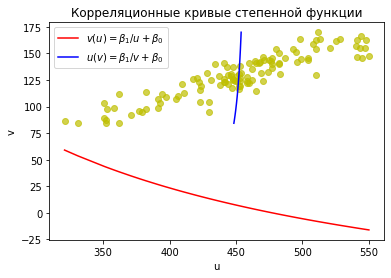

In [169]:
plt.scatter(source[0], source[1], alpha=0.7, color="y")
plt.plot(source[0].sort_values(), custom_v(source[0].sort_values()), label="$v(u)=\\beta_1/u + \\beta_0$", color="r")
plt.plot(custom_u(source[1].sort_values()), source[1].sort_values(), label="$u(v)=\\beta_1/v + \\beta_0$", color="b")
#plt.plot(params.loc["u", "mean"], params.loc["v", "mean"], color="k", marker="o", mew=2, ms=12)

plt.xlabel("u")
plt.ylabel("v")
plt.title("Корреляционные кривые степенной функции")
plt.legend()
plt.show()